In [4]:
import torch 
import pickle
import numpy as np
import torch.optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import nn_arz.nn_arz.datasets
import nn_arz.nn_arz.models
import nn_arz.nn_arz.polynomials
import nn_arz.nn_arz.lwr
import nn_arz.nn_arz.lwr.explicit
import nn_arz.nn_arz.lwr.lax_hopf
import importlib
importlib.reload(nn_arz.nn_arz.models)

from nn_arz.nn_arz.utils import get_mps_info

ModuleNotFoundError: No module named 'nn_arz.nn_arz'

In [ ]:
device = nn_arz.nn_arz.utils.get_device()

Using GPU : Quadro RTX 6000 (GPU 0) with 3.00 MiB used.
Using GPU : Quadro RTX 6000 (GPU 0) with 3 MiB used.


In [2]:
torch.manual_seed(420)

def dataset(
    tmax = 5e-1,
    xmax = 5e-1,
    dx = 1e-2,
    dt = 1e-3,  
    size = 512,
    batch_size=12,
    values=2,
    device='cpu',
    seed='420'
):
    torch.manual_seed(seed)

    ic = torch.rand(size, values)
    ratio = 20
    size = ic.shape[0]

    d = torch.empty((size, int(xmax//dx), int(tmax//dt)))
    for i in tqdm(range(size//batch_size)):
        temp = nn_arz.nn_arz.lwr.lax_hopf.Lax_Hopf_solver_Greenshield(
            ic[i*batch_size:(i+1)*batch_size], 
            dx=dx/ratio, 
            dt=dt, 
            Nx=ratio*int(xmax//dx), 
            Nt=int(tmax//dt), 
            flow = nn_arz.nn_arz.lwr.lax_hopf.triangular,
            device=device
        )
        d[i*batch_size:(i+1)*batch_size] = temp.reshape((
            temp.shape[0], 
            temp.shape[1], 
            temp.shape[2] // ratio, 
            ratio)
        ).mean(dim=3).transpose(1, 2)
    return d

# eval_dataset = dataset(
#     tmax = 1e-1,
#     xmax = 5e-1,#e-1,
#     dx = 1e-3,
#     dt = 1e-4,  
#     size = 128,
#     values=10,
#     batch_size=1,
#     device=device
# ).unsqueeze(-1).cpu()
# print(f'Eval dataset shape: {eval_dataset.shape}')

# eval_dataset = dataset(
#     tmax = 1,
#     xmax = 2,#e-1,
#     dx = 1e-2,
#     dt = 1e-3,  
#     size = 128,
#     values=10,
#     device=device,
#     batch_size=2
# ).unsqueeze(-1).cpu()
# print(f'Eval dataset shape: {eval_dataset.shape}')

eval_dataset_nathan = dataset(
    tmax = 1e-1,
    xmax = 2e-1,#e-1,
    dx = 1e-3,
    dt = 1e-4,  
    size = 100,
    values=10,
    device=device,
    batch_size=2
).unsqueeze(-1).cpu()
print(f'Eval dataset shape: {eval_dataset_nathan.shape}')

train_dataset = dataset(
    tmax = 5e-1,
    xmax = 1,#e-1,
    dx = 1e-2,
    dt = 1e-3,  
    size = 2048,
    # values=10,
    device=device,
).unsqueeze(-1).cpu()
print(f'Train dataset shape: {train_dataset.shape}')



NameError: name 'device' is not defined

In [5]:
f = lambda rho : nn_arz.nn_arz.lwr.lax_hopf.greenshield1['q'](
    rho, 
    flux=nn_arz.nn_arz.lwr.lax_hopf.greenshield1
)

rho_crit = nn_arz.nn_arz.lwr.lax_hopf.greenshield1['kcrit']
def godunov_flux(rho):
    fluxes = f(rho)  # Apply the flux function element-wise
    # Conditions based on the problem
    flows = torch.where(
        rho[:, :-1] <= rho[:, 1:],  # Condition 1: rho[i] <= rho[i+1]
        torch.minimum(fluxes[:, :-1], fluxes[:, 1:]),  # Min flux
        torch.where(
            rho[:, 1:] > rho_crit,  # Condition 2: rho[i+1] > rho_max
            fluxes[:, 1:],  # Use flux[i+1]
            torch.where(
                rho_crit> rho[:, :-1],  # Condition 3: rho[i] < rho_max
                fluxes[:, :-1],  # Use flux[i]
                f(torch.tensor(rho_crit, device=rho.device))  # Use f(rho_max)
            )
        )
    )
    return flows

In [6]:
def get_compactly_supported_polynomials(x_fine, batch_size, degree, device, x=None):
    if x is None:
        x = x_fine
    coefsP = torch.rand((batch_size, degree), requires_grad=False) - 1/2
    coefsP[:, -2:] = 0
    XcoefsP = torch.roll(coefsP, shifts=[1], dims=[1])
    XcoefsP[:, 0] = 0
    minus_xmax_coefsP = - coefsP * x_fine[-1]
    coefsP = XcoefsP + minus_xmax_coefsP

    XcoefsP = torch.roll(coefsP, shifts=[1], dims=[1])
    XcoefsP[:, 0] = 0
    minus_xmin_coefsP = - coefsP * x_fine[0]
    coefsP = XcoefsP + minus_xmin_coefsP

    P = nn_arz.nn_arz.polynomials.BatchPolynomial(coefsP)
    with torch.no_grad():
        p, p_antiderivative = P(x_fine).unsqueeze(-1).unsqueeze(-1).to(device), P.antiderivative()(x).unsqueeze(-1).unsqueeze(-1).to(device)
    return p, p_antiderivative

In [7]:
class flowModelTest(nn.Module):
    def __init__(self, 
                dx: float = 1.,
                dt: float = 1.,
                clamp=1.):
        #register dx and dt at parent class level
        super(flowModelTest, self).__init__()

        self.dx = dx
        self.dt = dt
        

        self.conv1 = nn.Conv1d(5, 16, kernel_size=6, stride=1)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=1, stride=1)
        self.conv3 = nn.Conv1d(16, 16, kernel_size=1, stride=1)
        self.conv4 = nn.Conv1d(16, 16, kernel_size=1, stride=1)
        self.conv5 = nn.Conv1d(16, 16, kernel_size=1, stride=1)
        self.conv6 = nn.Conv1d(16, 1, kernel_size=1, stride=1)

        self.clamp = clamp

    def forward(self, x, density=False):
        rho = x.transpose(1, 3).squeeze(-1).clone()
        if rho.shape[1] < 5:
            p = (5-rho.shape[1])//2
            # rho = F.pad(rho, (0, 1, p, p + (0 if (5-rho.shape[1])%2 == 0 else 1)), mode='replicate')
            rho = F.pad(rho, (2, 3, 5-rho.shape[1], 0), mode='replicate')
        else:
            rho = F.pad(rho, (2, 3, 0, 0), mode='replicate')
        # print(x.shape)
        # rho = x.clone()
        # x = x.unsqueeze(1)
        rho = F.tanh(self.conv1(rho))
        rho = F.tanh(self.conv2(rho))
        rho = F.tanh(self.conv3(rho))
        rho = F.tanh(self.conv4(rho))
        rho = F.tanh(self.conv5(rho))
        rho = self.conv6(rho)
        # print(rho.shape, x.shape)
        flowR = torch.clamp(rho, min=0., max=self.clamp).unsqueeze(-1)


        flowR = torch.cat((flowR[:,:,0].unsqueeze(-1), flowR) , dim=2).to(x.device)
        return x[:, :, :, [-1]] - (self.dt/self.dx) * (flowR[:,:,1:] - flowR[:,:,:-1])



In [ ]:
def loss_func(u_, p, p_antiderivative, dx, dt, verbose=True):
    mf = (u_[:, :, 1:] - u_[:, :, :-1])/dt 
    f_ = f(u_[:, :-1, :-1])
    if f_.isnan().any().item() or u_.isnan().any().item():
        print('f', f_.isnan().any().item(), 'u', u_.isnan().any().item())
    vect_total_mf = (mf[:, :-1].unsqueeze(1) * (p_antiderivative[:, 1:] - p_antiderivative[:, :-1]))#[:, :, :-1]
    if vect_total_mf.isnan().any().item():
        print('vect_total_mf', vect_total_mf.isnan().any().item(), p_antiderivative.isnan().any().item())
    # print(vect_total_mf.shape, f_.unsqueeze(1).shape, ( (p[:, 1:] - p[:, :-1]).unsqueeze(0)).shape, ((- f_.unsqueeze(1) * (p[:, 1:] - p[:, :-1]).unsqueeze(0))[:, :, :-1]).shape)
    vect_total_mf -= (f_.unsqueeze(1) * (p[:, 1:] - p[:, :-1]).unsqueeze(0))#[:, :, :-1]
    if vect_total_mf.isnan().any().item():
        print('vect_total_mf1', vect_total_mf.isnan().any().item())
    # godu_ = f_ 
    # vect_total_mf += (p[:, 1:-1].unsqueeze(0)*godu_[:, 1:].unsqueeze(1) - p[:, :-2].unsqueeze(0)*godu_[:, :-1].unsqueeze(1))
    #vect_total_mf /= f_.sum(dim=1, keepdim=True).unsqueeze(1)
    loss = (vect_total_mf.sum(dim=2)**2).mean()#.mean(dim=2).mean(dim=0).sum()
    if loss.isnan().any().item():
        print('loss', loss.isnan().any().item())

    # loss += ((abs(u_[:, 1:, -1] - u_[:, :-1, -1]))).mean() * 5e-4
    # loss += ((abs(u_[:, 1:, -1] - u_[:, :-1, -1])))[abs(u_[:, 1:, -1] - u_[:, :-1, -1]) < .8 * abs(u_[:, 1:, 0] - u_[:, :-1, 0]).max().item()].mean() * 5e-2
    # return (vect_total_mf.sum(dim=2).sum(dim=1)**2).mean()#.mean(dim=2).mean(dim=0).sum()

    # Total variation of u
    # mask = (u_[:, 0, 0] > u_[:, -1, 0]).squeeze()
    # mask2 = ((u_[:, [0], 0] > u_[:, [-1], 0]) * (abs(u_[:, [0], -1] - .5) < 1e-1)).squeeze()
    mask2 = ((u_[:, [0], 0] > u_[:, [-1], 0])).squeeze()

    loss += torch.clamp(abs(u_[:, 1:, -1] - u_[:, :-1, -1]), max=1e-1).mean() * 1e-8
    if mask2.any():
        loss += (abs(u_[:, 1:, -1] - u_[:, :-1, -1])**2)[mask2].mean() * 5e-7 # 1e-7

    return loss * 1e+10

def weak_loss(p, p_antiderivative, q, dx, dt, verbose=False):
    return lambda u_: loss_func(u_, p, p_antiderivative, dx, dt, verbose)


model = flowModelTest(clamp=.25).to(device)
model.load_state_dict(torch.load("models/greenshield_2D2_save.pth"))

model.dx = 1e-2
model.dt = 1e-3

model.train()

for nts in [250]:
    train(model=model, 
          dataset=train_dataset.flip(2), 
          nts=nts,
          learning_rate=1e-5,#1e-5,
          patience=2000000,
          decay=0.99,
          epochs=20000,
          batch_size=512,#Should not be defined
          k1=50,
          dx=model.dx,
          dt=model.dt) # Droptout ?

/tmp/ipykernel_2227479/4000711724.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/greenshield_2D2_save.pth"))
/tmp/ipykernel_22

Epoch:   0%|          | 50/20000 [12:07<120:04:58, 21.67s/it, loss=5.14310307e-06, loss_numerical=6.01200791e-05, loss_rho=5.14310307e-06, lr=1.00e-05]

MSE 4.77e-05 std 6.54e-05
Numerical MSE 4.27e-04 std 1.68e-04
Better 99.00%


Epoch:   0%|          | 100/20000 [30:20<134:41:58, 24.37s/it, loss=5.11595567e-06, loss_numerical=5.99843652e-05, loss_rho=5.11595567e-06, lr=1.00e-05]

MSE 4.86e-05 std 6.58e-05
Numerical MSE 4.27e-04 std 1.68e-04
Better 99.00%


Epoch:   1%|          | 113/20000 [35:24<129:26:28, 23.43s/it, loss=5.10898622e-06, loss_numerical=6.00279045e-05, loss_rho=5.10898622e-06, lr=1.00e-05]

In [9]:
def train(model, dataset, nts, learning_rate, patience, decay, epochs, k1, dx, dt, batch_size=None):
    model.train()

    Nx = dataset.shape[1]
    border = max((Nx-2*nts)//2 - 1, 0)
    # dataset=dataset[:, border:-(border+1), -nts::].flip(2)
    dataset=dataset[:, :, -nts::].flip(2)

    
    model.to(device)
    if batch_size is None:
        batch_size = dataset.shape[0]
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # LR scheduler
    min_lr = 5e-9
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode = 'min',
        patience = patience,
        factor=0.5,
        cooldown = 2*patience,
        eps = 0.1*min_lr,
        min_lr=min_lr)

    x = torch.range(0, dataset.shape[1] - 1) * dx - dataset.shape[1]//2 * dx
    x_fine = torch.range(0, 10*dataset.shape[1] - 1) * dx/10 - dataset.shape[1]//2 * dx
    t = torch.range(0, nts - 1) * dt

    best_mse = 1e10
    with tqdm(range(epochs), desc="Epoch") as pbar:
    # for epoch in range(epochs):  
        for epoch in pbar:
            # if epoch == 0:
            if epoch % 2000000 == 0:
                p, p_antiderivative = get_compactly_supported_polynomials(x, 250, 50, device, x=None)
                a = p.max(dim=1).values.unsqueeze(1)
                # p = p/a
                # p_antiderivative = p_antiderivative/a
                # print(p.shape)
                # p = p.view(250, -1)
                # p = p.view(250, x.shape[0], 10)
                # print(p.shape)
                # p = p.mean(-1)
                # print(p.shape)
                # p = p.view(250, x.shape[0], 1, 1)
                # print(p.shape)
                # p = p.view(250, x.shape[0], 10).mean(-1).view(250, x.shape[0], 1, 1)
                # plt.plot(x, p[0].flatten().cpu())
                # return
                # p_antiderivative = p_antiderivative.view(250, x.shape[0], 10).mean(-1).view(250, x.shape[0], 1, 1)

                loss = weak_loss(p, p_antiderivative, None, dx, dt, verbose=False)

            losses = []
            losses_rho = []
            losses_numerical = []
            with tqdm(dataloader, desc=f"Epoch {epoch}:", disable=True) as pbar1:
                for data in pbar1:
                    data = {
                        'rho': data[:, :, :, 0],
                        'u': data[:, :, :, [0]]
                    }

                    u_n = data['u'].to(device)
                    u_hat_t = u_n[:, :, [0]].clone()

                    l = 0
                    l_rho = 0
                    u_hat = u_n.clone()
                    u_num = u_n.clone()

                    for t in range(5, u_n.shape[2]):
                        u_hat_old = u_hat_t#.clone()
                        # u_hat_t, _ = model(u_hat_old.transpose(1, 2), density=False)

                        # u_hat_t = torch.clip(u_hat_t.transpose(1, 2), min=0, max=1.)
                        # u_hat_t = torch.clamp(model(u_hat[:, :, max(t-5, 0):max(1, t)].permute(0, 3, 1, 2), density=False).permute(0, 2, 3, 1), min=0., max=1.)                 
                        u_hat_t = torch.clamp(model(u_hat[:, :, max(t-5, 0):max(1, t)].permute(0, 3, 1, 2), density=False).permute(0, 2, 3, 1), min=0., max=1.)                 

                    

                        flow = godunov_flux(u_num[:, :, t-1].detach())
                        u_num[:, 1:-1, t] = u_num[:, 1:-1, t-1].detach() - (flow[:, 1:] - flow[:, :-1]) * dt/dx

                        u_num[:, [0, -1], t] = u_n[:, [0, -1], t].detach()

                        u_hat[:, :, t] = u_hat_t.squeeze(-1)
                        # u_hat[:, [0, -1], t] = u_n[:, [0, -1], t]
                        u_hat[:, :3, t] = u_num[:, :3, t]
                        u_hat[:, -4:, t] = u_num[:, -4:, t]

                        with torch.no_grad():
                            l_rho += F.mse_loss(u_hat_t[:, :, [0], 0], u_n[:, :, [t], 0])/u_n.shape[2]

                    # l2 = loss(u_hat) #* 1e20
                    l_numerical = F.mse_loss(u_hat[:, :, 1:], u_num[:, :, 1:])
                    l_rho = F.mse_loss(u_hat[:, :, 1:], u_n[:, :, 1:])
                    # l_numerical = F.mse_loss(u_n[:, :, 1:], u_num[:, :, 1:])
                    # l = l2 #+ l_numerical #* 1e-2
                    l = l_rho
                    l2 = l
                    # optimizer.zero_grad(set_to_none=True)
                    l.backward()
                    optimizer.step()
                    # optimizer_refine.step()
                    optimizer.zero_grad(set_to_none=True)
                    # optimizer_refine.zero_grad(set_to_none=True)

                    scheduler.step(l.detach_())
                    losses.append(l2.item())
                    losses_rho.append(l_rho.item())
                    losses_numerical.append(l_numerical.item())
                
            pbar.set_postfix(loss=f'{np.mean(losses):.8e}', loss_rho=f'{np.mean(losses_rho):.8e}', loss_numerical=f'{np.mean(losses_numerical):.8e}', lr=f'{scheduler._last_lr[0]:.2e}')
            
            if ((epoch + 1) % 50) == 0:
                with torch.no_grad():
                    mse = eval()
                    model.dt = dt
                    model.dx = dx
                    model.train()
                if mse < best_mse:
                    torch.save(model.state_dict(), 'models/greenshield_2D2_save.pth')

                best_mse = min(mse, best_mse)
            
            del l, l2, l_rho, l_numerical, u_hat, u_hat_t, u_hat_old, flow, u_num
            # writer.add_scalar('train/Loss', np.mean(losses), epoch)
            # writer.add_scalar('train/Loss supervised', np.mean(losses_rho), epoch)
            # writer.add_scalar('train/Learning rate', scheduler._last_lr[0], epoch)

            if optimizer.param_groups[0]['lr'] <= min_lr:
                print("Early stopping")
                break

            # if epoch%100 == 0:       
                # torch.save(model.state_dict(), f'models/model_lwr_our_{nts}_{epoch}.pth')
        
    nn_arz.nn_arz.utils.empty_cache()
    del dataloader
    del optimizer
    del scheduler
    import gc
    gc.collect()

MSE 5.22e-05 std 7.53e-05
Numerical MSE 4.27e-04 std 1.68e-04
Better 99.00%


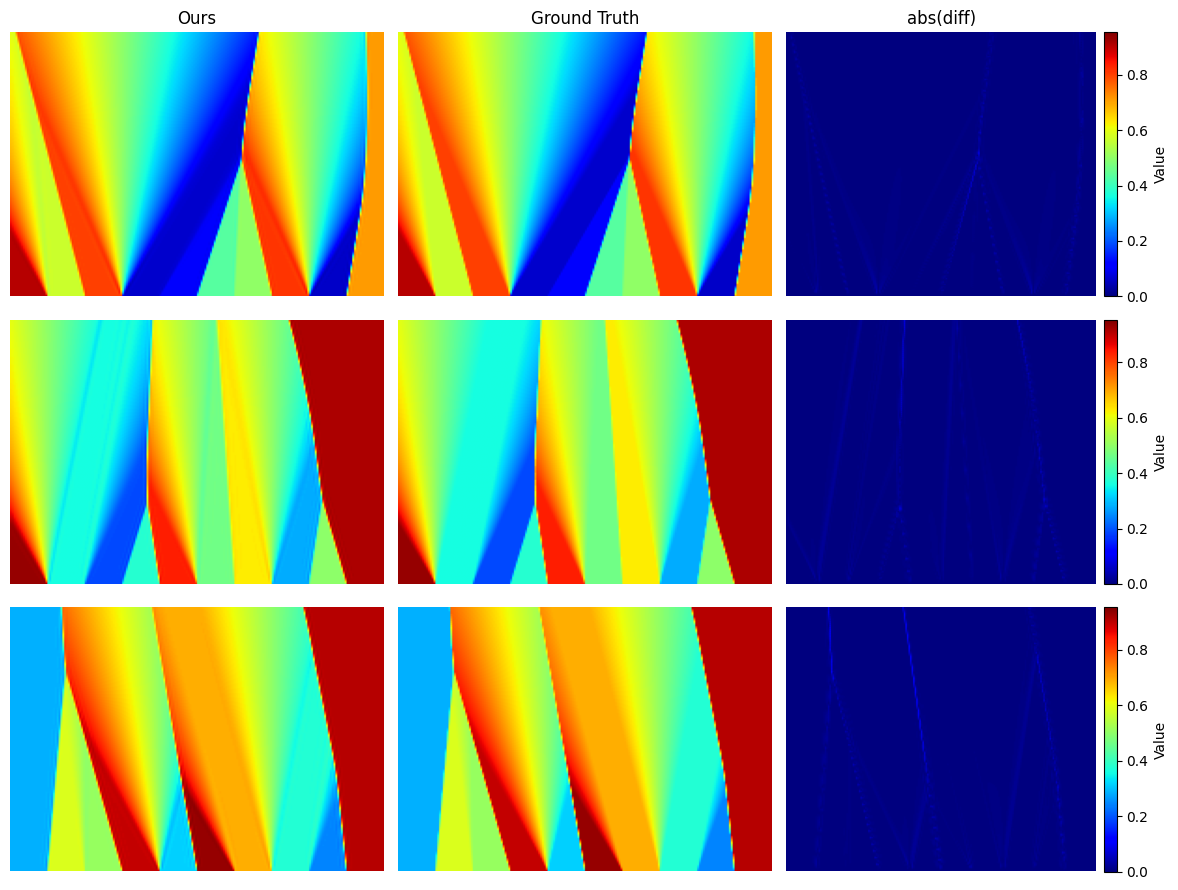

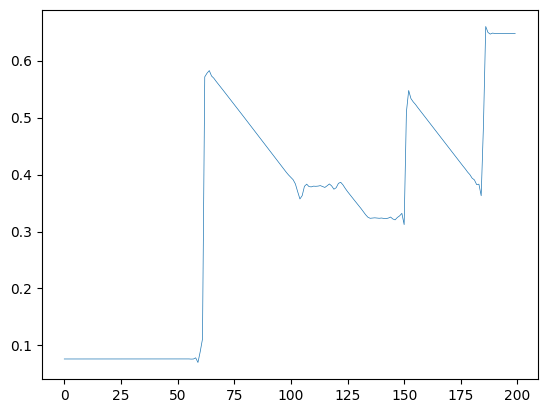

In [ ]:
# eval_rare = eval_dataset.squeeze(-1)[(eval_dataset[:, 0, 0, 0] < eval_dataset[:, -1, 0,0])].unsqueeze(-1)

def eval(viz=False, all=False, nt=999):
    dataloader_ = DataLoader(eval_dataset_nathan.squeeze(-1).flip(1), batch_size=eval_dataset_nathan.shape[0], shuffle=True)

    model.dt = 1e-4
    model.dx = 1e-3
    model.eval()

    # nt = 299
    # nt = 1200
    error = 0
    better = 0
    with torch.no_grad():
        for data in dataloader_:
            # data = {
            #     'rho': data[:, :, :, 0].flip(2),
            #     'u': data[:, :, :, [0]].flip(2)
            # }
            data = {
                'rho': data[:, :, :].flip(1),
                'u': data[:, :, :].flip(1).unsqueeze(-1)
            }

            u_n = data['u'].to(device)        

            u_n_hat = u_n.clone()
            u_godu = u_n.clone()

            for i in range(5, nt):
                flow = godunov_flux(u_godu[:, :, i-1].detach())
                u_godu[:, 1:-1, i] = u_godu[:, 1:-1, i-1].detach() - (flow[:, 1:] - flow[:, :-1]) * model.dt/model.dx
                # u_n_hat[:, :,[i]] = torch.clip(model(u_n_hat[:, :, [i-1]].transpose(1, 2), density =False)[0].transpose(2, 1), min=0, max=1.)
                u_n_hat[:, :,[i]] = torch.clamp(model(u_n_hat[:, :, max(i-5, 0):max(1, i)].permute(0, 3, 1, 2), density=False).permute(0, 2, 3, 1), min=0., max=1.)                 

                # u_n_hat[:, :,[i]] = model_refine(u_n_hat[:, :,[i]].transpose(1, 2)).transpose(1, 2)



                #####
                u_n_hat[:, 0,[i]] = u_n[:, 0,[i]]
                u_godu[:, 0,[i]] = u_n[:, 0,[i]]
                u_n_hat[:, -1,[i]] = u_n[:, -1,[i]]
                u_godu[:, -1,[i]] = u_n[:, -1,[i]]
                # u_n_hat[:, [0, -1],[i]] = u_n[:, [0, -1], [0]]
                # u_godu[:, [0, -1], [i]] = u_n[:, [0, -1], [0]]
                # u_godu[:, [0, -1], [i]] = u_godu[:, [0, -1], [i-1]]


            rho = u_n_hat[:, :, :, 0].detach().cpu()
            rho_num = u_godu[:, :, :, 0].detach().cpu()

            diff_abs_rho = (data['rho'] - rho).abs()
            diff_abs_num = (data['rho'] - rho_num).abs()

            error = F.mse_loss(rho, data['rho'], reduce=False).mean(dim=1).mean(dim=1)
            error_num = F.mse_loss(rho_num, data['rho'], reduce=False).mean(dim=1).mean(dim=1)
            ordered = torch.argsort(error).flip(0)

            better += (F.mse_loss(rho, data['rho'], reduction='none').mean(dim=1).mean(dim=1) <= F.mse_loss(rho_num, data['rho'], reduction='none').mean(dim=1).mean(dim=1)).sum().item() / rho.shape[0]
            print(f'MSE {error.mean():.2e} std {error.std():.2e}')
            print(f'Numerical MSE {F.mse_loss(rho_num, data["rho"]):.2e} std {error_num.std():.2e}')
            print(f'Better {better*100:.2f}%')

            if viz:
                to_display = torch.stack([rho[:3, :, :nt], data['rho'][:3, :, :nt], diff_abs_rho[:3, :, :nt]]).transpose(0, 1)

                nn_arz.nn_arz.utils.plot_matrices(to_display, titles=['Ours', 'Ground Truth', 'abs(diff)'], xlabel='rho', ylabel='t', cmap='jet', extent=[-1e-2*802/2, 1e-2*802/2, 0, 2.5e-3*400])

                plt.plot(rho[-1, :, nt-1], linewidth=0.5)
                plt.show()
            break
        if all:
            return error.mean(), data, rho, rho_num
        return error.mean()

_, data, rho, rho_num = eval(all=True, viz=True, nt=999)
# _, data, rho, rho_num = eval(all=True, viz=True, nt=999)


# sup
# MSE 5.22e-05 std 7.53e-05
# Numerical MSE 4.27e-04 std 1.68e-04
# Better 99.00%

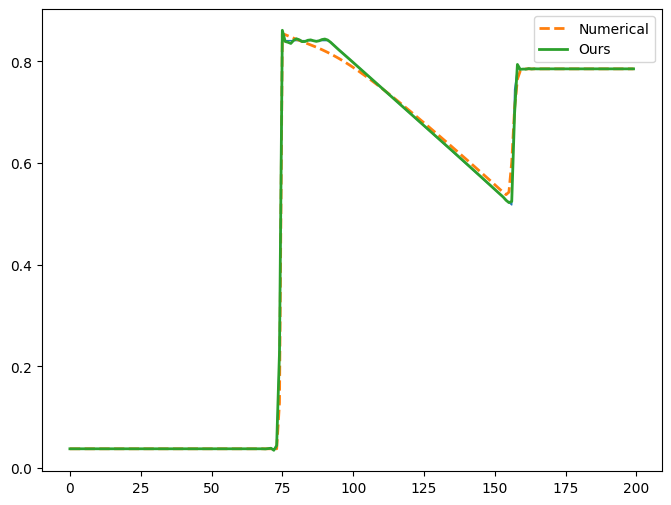

39


In [45]:
nt = -1
plt.figure(figsize=(8, 6))
i = torch.randint(rho.shape[0], [1]).item()
plt.plot(data['rho'][i, :, nt-1], linewidth=1)
plt.plot(rho_num[i, :, nt-1], linewidth=2, label='Numerical', linestyle='--')
plt.plot(rho[i, :, nt-1], linewidth=2, label='Ours')
plt.legend()
plt.show()
print(i)

In [ ]:
print(f"Allocated memory: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
print(f"Cached memory: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")


def log_cuda_tensors():
    import gc
    tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                del obj
                # tensors.append(obj)
        except ReferenceError:
            # Skip objects that no longer exist
            pass
    for i, t in enumerate(tensors):
        print(f"Tensor {i}: size={t.size()}, memory={t.element_size() * t.nelement() / 1024 ** 2:.2f} MB")
        del t

log_cuda_tensors()

with torch.cuda.device(device):
    torch.cuda.empty_cache()

Allocated memory: 22081.74 MB
Cached memory: 22092.00 MB


/scratch/acanesse/alexi/lib/python3.11/site-packages/torch/__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [ ]:
nn_arz.nn_arz.utils.empty_cache()
# del dataloader
# del omptimizer
# del scheduler
import gc
gc.collect()

1690

In [43]:
torch.save(model.state_dict(), 'models/greenshield_2D2_sup.pth')

torch.Size([1000])


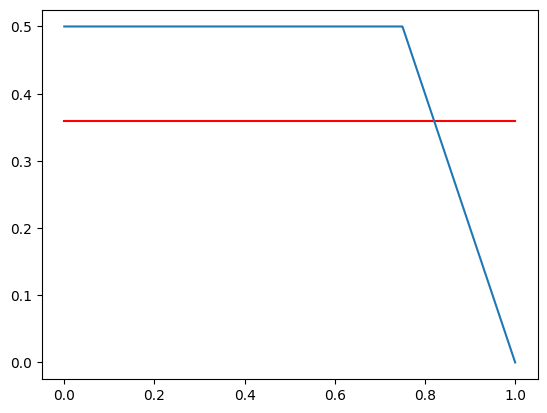

In [ ]:
x = torch.linspace(0, 1, 1000)
x1 = torch.ones_like(x) * .8

flx_g = godunov_flux(torch.stack([x1, x]).T)
flx = model(torch.stack([x, x1]).T.unsqueeze(1).unsqueeze(-1).to(device))[1].squeeze().detach().cpu()[:, -1]
print(flx.shape)
# plt.plot(x, nn_arz.nn_arz.lwr.lax_hopf.trapezoidal['q'](x, nn_arz.nn_arz.lwr.lax_hopf.trapezoidal))
plt.plot(x, flx.squeeze(), color='red')
plt.plot(x, flx_g.squeeze())
# plt.plot(godunov_flux(x.unsqueeze(0)).squeeze())

In [ ]:
from torchinfo import summary
summary(model)


Layer (type:depth-idx)                   Param #
flowModelTest                            --
├─Conv1d: 1-1                            176
├─Conv1d: 1-2                            272
├─Conv1d: 1-3                            272
├─Conv1d: 1-4                            272
├─Conv1d: 1-5                            272
├─Conv1d: 1-6                            17
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0